In [1]:
import read_data as imp
import numpy as np
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import Alphas101 as Alphas

import calendar

import itertools as it

import warnings
warnings.filterwarnings("ignore")

C:\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; mutltipliers will not be applied' +
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Anaconda3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def set_date(year_month,day):
    return str(year_month[0])+'-'+str(year_month[1])+'-'+str(day)

def get_ret(hist_prices, index, buy = [], sell = []):
    pyg_long = 0
    pyg_short = 0
    
    if len(buy) != 0:
        for name in buy:
            pyg_long += hist_prices[name]['ret'][index]
    
    if len(sell) != 0:
        for name in sell:
            pyg_short += -1 * hist_prices[name]['ret'][index]
    
    return pyg_long + pyg_short

symbols = list(pd.read_csv("Tickers.txt", sep="\n", header=None)[0].values)
symbols = ['XLP','XLY','XLE','XLF','XLV','XLI','XLK','XLU']
#            'EWA', 'EWC', 'EWG','EWH', 'EWJ', 'EWL', 'EWP', 'EWW', 'EWU', 'EWY', 'EWZ', 'INDA']

path_features = "Features.txt"
features = list(pd.read_csv(path_features, sep="\n", header=None)[0].values)

# comission and bid_ask_spread
com = 0.0015
BidAskSpread = 0.00016

In [3]:
years = [x for x in range(2008,2020)]
months = [x+1 for x in range(12)]
years_months = list(it.product(*[years,months]))
ld_month = [calendar.monthrange(x[0],x[1])[1] for x in years_months]
Rebalancing_dates = pd.to_datetime([y for y in map(set_date, years_months, ld_month)])

Bkt_Size = 4

In [4]:
hist_data = imp.organizarTodo(symbols,years)
hist_feature = imp.organizarTodo(features,years,True)



Rebalancing_dates = []

curr_month = hist_data['XLP'].index[0].month

for i in range(1,len(hist_data['XLP'].index)):
    if hist_data['XLP'].index[i].month != curr_month:
        Rebalancing_dates.append(hist_data['XLP'].index[i-1])
        curr_month = hist_data['XLP'].index[i].month
        
Rebalancing_dates = pd.to_datetime(Rebalancing_dates)
the_start = Rebalancing_dates[Rebalancing_dates >= hist_data['XLP'].index[200]][0]
ind = np.logical_and(Rebalancing_dates <= hist_data['XLP'].index[-1], Rebalancing_dates >= the_start)
Rebalancing_dates = Rebalancing_dates[ind]

## Calculating the factors over time

In [5]:
for etf,data in hist_data.items():
    df = data.copy()
    df['ret'] = df['Close'].pct_change()
    df['Alpha1'] = 0.0
    df['Alpha101'] = 0.0
    df['Alpha2'] = 0.0
    df['Alpha3'] = 0.0
    df['Alpha44'] = 0.0
    df['Alpha53'] = 0.0
    df['Alpha54'] = 0.0
    df['Alpha6'] = 0.0
    df['AlphaMAR'] = 0.0
    
    for i in Rebalancing_dates[Rebalancing_dates >= the_start]:
        df['Alpha1'][i] = Alphas.alpha1(data.iloc[df.index <= i,])
        df['Alpha101'][i] = Alphas.alpha101(df.iloc[df.index <= i,])
        df['Alpha2'][i] = Alphas.alpha2(df.iloc[df.index <= i,])
        df['Alpha3'][i] = Alphas.alpha3(df.iloc[df.index <= i,])
        df['Alpha44'][i] = Alphas.alpha44(df.iloc[df.index <= i,])
        df['Alpha53'][i] = Alphas.alpha53(df.iloc[df.index <= i,])
        df['Alpha54'][i] = Alphas.alpha54(df.iloc[df.index <= i,])
        df['Alpha6'][i] = Alphas.alpha6(df.iloc[df.index <= i,])
        df['AlphaMAR'][i] = Alphas.mar(df.iloc[df.index <= i,])
        
    hist_data[etf] = df

In [6]:
Strategies = ['LA1','SA1','LSA1',
              'LA101','SA101','LSA101',
              'LA2','SA2','LSA2',
              'LA3','SA3','LSA3',
              'LA44','SA44','LSA44',
              'LA53','SA53','LSA53',
              'LA54','SA54','LSA54',
              'LA6','SA6','LSA6',
              'LAMAR','SAMAR','LSAMAR']

Strategy_Ret = pd.DataFrame(index = hist_data['XLP'].index[hist_data['XLP'].index >= the_start],
                            columns = Strategies, dtype = 'float')

LA1_basket = []; SA1_basket = []

LA101_basket = []; SA101_basket = []

LA2_basket = []; SA2_basket = []

LA3_basket = []; SA3_basket = []

LA44_basket = []; SA44_basket = []

LA53_basket = []; SA53_basket = []

LA54_basket = []; SA54_basket = []

LA6_basket = []; SA6_basket = []

LAMAR_basket = []; SAMAR_basket = []

    
for i in Strategy_Ret.index:
            
    if i in Rebalancing_dates:
        
        # update Baskets
        
        LA1_basket = pd.DataFrame({k:d['Alpha1'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LA1_basket = list(LA1_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SA1_basket = pd.DataFrame({k:d['Alpha1'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SA1_basket = list(SA1_basket.sort_values(by=['0']).index[0:Bkt_Size])
        
        LA101_basket = pd.DataFrame({k:d['Alpha101'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LA101_basket = list(LA101_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SA101_basket = pd.DataFrame({k:d['Alpha101'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SA101_basket = list(SA101_basket.sort_values(by=['0']).index[0:Bkt_Size])
        
        LA2_basket = pd.DataFrame({k:d['Alpha2'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LA2_basket = list(LA2_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SA2_basket = pd.DataFrame({k:d['Alpha2'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SA2_basket = list(SA2_basket.sort_values(by=['0']).index[0:Bkt_Size])
        
        LA3_basket = pd.DataFrame({k:d['Alpha3'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LA3_basket = list(LA3_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SA3_basket = pd.DataFrame({k:d['Alpha3'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SA3_basket = list(SA3_basket.sort_values(by=['0']).index[0:Bkt_Size])
        
        LA44_basket = pd.DataFrame({k:d['Alpha44'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LA44_basket = list(LA44_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SA44_basket = pd.DataFrame({k:d['Alpha44'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SA44_basket = list(SA44_basket.sort_values(by=['0']).index[0:Bkt_Size])
        
        LA53_basket = pd.DataFrame({k:d['Alpha53'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LA53_basket = list(LA53_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SA53_basket = pd.DataFrame({k:d['Alpha53'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SA53_basket = list(SA53_basket.sort_values(by=['0']).index[0:Bkt_Size])
        
        LA54_basket = pd.DataFrame({k:d['Alpha54'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LA54_basket = list(LA54_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SA54_basket = pd.DataFrame({k:d['Alpha54'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SA54_basket = list(SA54_basket.sort_values(by=['0']).index[0:Bkt_Size])
        
        LA6_basket = pd.DataFrame({k:d['Alpha6'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LA6_basket = list(LA6_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SA6_basket = pd.DataFrame({k:d['Alpha6'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SA6_basket = list(SA6_basket.sort_values(by=['0']).index[0:Bkt_Size])
                
        LAMAR_basket = pd.DataFrame({k:d['AlphaMAR'][i] for k,d in hist_data.items()},index=['0']).transpose()
        LAMAR_basket = list(LAMAR_basket.sort_values(by=['0'],ascending=False).index[0:Bkt_Size])
        
        SAMAR_basket = pd.DataFrame({k:d['AlphaMAR'][i] for k,d in hist_data.items()},index=['0']).transpose()
        SAMAR_basket = list(SAMAR_basket.sort_values(by=['0']).index[0:Bkt_Size])
        
        # Return calculus
        
        Strategy_Ret.loc[i,['LA1']] = get_ret(hist_data, i, buy= LA1_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA1']] = get_ret(hist_data, i, sell= SA1_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA1']] = get_ret(hist_data, i, buy= LA1_basket, sell= SA1_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA101']] = get_ret(hist_data, i, buy= LA101_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA101']] = get_ret(hist_data, i, sell= SA101_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA101']] = get_ret(hist_data, i, buy= LA101_basket, sell= SA101_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA2']] = get_ret(hist_data, i, buy= LA2_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA2']] = get_ret(hist_data, i, sell= SA2_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA2']] = get_ret(hist_data, i, buy= LA2_basket, sell = SA2_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA3']] = get_ret(hist_data, i, buy= LA3_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA3']] = get_ret(hist_data, i, sell= SA3_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA3']] = get_ret(hist_data, i, buy= LA3_basket, sell= SA3_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA44']] = get_ret(hist_data, i, buy= LA44_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA44']] = get_ret(hist_data, i, sell= SA44_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA44']] = get_ret(hist_data, i, buy= LA44_basket, sell= SA44_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA53']] = get_ret(hist_data, i, buy= LA53_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA53']] = get_ret(hist_data, i, sell= SA53_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA53']] = get_ret(hist_data, i, buy= LA53_basket, sell= SA53_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA54']] = get_ret(hist_data, i, buy= LA54_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA54']] = get_ret(hist_data, i, sell= SA54_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA54']] = get_ret(hist_data, i, buy= LA54_basket, sell= SA54_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA6']] = get_ret(hist_data, i, buy= LA6_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA6']] = get_ret(hist_data, i, sell= SA6_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA6']] = get_ret(hist_data, i, buy= LA6_basket, sell= SA6_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LAMAR']] = get_ret(hist_data, i, buy= LAMAR_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SAMAR']] = get_ret(hist_data, i, sell= SAMAR_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSAMAR']] = get_ret(hist_data, i, buy= LAMAR_basket, sell= SAMAR_basket)*(1-com)*(1-BidAskSpread)
        
    else:
        
        Strategy_Ret.loc[i,['LA1']] = get_ret(hist_data, i, buy= LA1_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA1']] = get_ret(hist_data, i, sell= SA1_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA1']] = get_ret(hist_data, i, buy= LA1_basket, sell= SA1_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA101']] = get_ret(hist_data, i, buy= LA101_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA101']] = get_ret(hist_data, i, sell= SA101_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA101']] = get_ret(hist_data, i, buy= LA101_basket, sell= SA101_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA2']] = get_ret(hist_data, i, buy= LA2_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA2']] = get_ret(hist_data, i, sell= SA2_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA2']] = get_ret(hist_data, i, buy= LA2_basket, sell = SA2_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA3']] = get_ret(hist_data, i, buy= LA3_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA3']] = get_ret(hist_data, i, sell= SA3_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA3']] = get_ret(hist_data, i, buy= LA3_basket, sell= SA3_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA44']] = get_ret(hist_data, i, buy= LA44_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA44']] = get_ret(hist_data, i, sell= SA44_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA44']] = get_ret(hist_data, i, buy= LA44_basket, sell= SA44_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA53']] = get_ret(hist_data, i, buy= LA53_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA53']] = get_ret(hist_data, i, sell= SA53_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA53']] = get_ret(hist_data, i, buy= LA53_basket, sell = SA53_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA54']] = get_ret(hist_data, i, buy= LA54_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA54']] = get_ret(hist_data, i, sell= SA54_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA54']] = get_ret(hist_data, i, buy= LA54_basket, sell= SA54_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LA6']] = get_ret(hist_data, i, buy= LA6_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SA6']] = get_ret(hist_data, i, sell= SA6_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSA6']] = get_ret(hist_data, i, buy= LA6_basket, sell= SA6_basket)*(1-com)*(1-BidAskSpread)
        
        Strategy_Ret.loc[i,['LAMAR']] = get_ret(hist_data, i, buy= LAMAR_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['SAMAR']] = get_ret(hist_data, i, sell= SAMAR_basket)*(1-com)*(1-BidAskSpread)
        Strategy_Ret.loc[i,['LSAMAR']] = get_ret(hist_data, i, buy= LAMAR_basket, sell= SAMAR_basket)*(1-com)*(1-BidAskSpread)

In [10]:
Strategy_Returns = pd.DataFrame()

for col in Strategy_Ret.columns:
    if pf.timeseries.perf_stats(Strategy_Ret[col])['Sharpe ratio'] >= 0.5:
        Strategy_Returns[col] = Strategy_Ret[col]

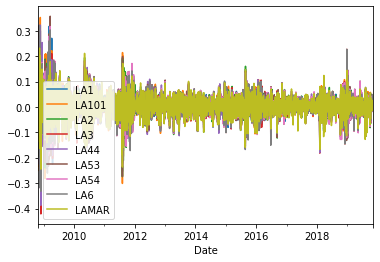

In [12]:
Strategy_Returns.plot()

In [15]:
Strategy_Prices_TS = 100 * (Strategy_Ret+1).cumprod()
# Strategy_Prices_TS.to_csv('Rentabilidad de estrategias base 100.csv')
Strategy_Returns.to_csv('Rentabilidad de estrategias base 100.csv')